<center><font size="6"><b>CPS - Projekt</b></font></center>
<br />
<center><font size="5"><b><u>Frequency equalizer</u></b></font></center>

Poniższy notatnik zawiera napisany w języku Python kod programu dokonującego equalizacji częstotliwościowej sygnału dowolnego sygnału, docelowo sygnału audio. Notatnik jest podzielony na cztery główne części:
- <span style="font-size: 12px">funkcja generująca filtry analizy i syntezy,
- <span style="font-size: 12px">funkcja equalizer() reazlizująca tytułową equalizację,
- <span style="font-size: 12px">przykładowe użycie programu,
- <span style="font-size: 12px">odpowiedź częstotliwościowa filtrów

Autorzy: Wojciech Bernaś, Mirosław Smoroński

In [1]:
#Import niezbędnych bibliotek
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.io.wavfile import read, write
import IPython.display as ipd
from tqdm import tqdm
from pathlib import Path
import requests

In [2]:
#Pobranie pliku "epic_sax_guy_single_channel.wav"
def download(url, path):
    if not isinstance(path, Path):
        path = Path(path)
    if not path.is_file():
        r = requests.get(url)
        with open(path, "wb") as f:
            f.write(r.content)
            
urls = {
    "epic_sax_guy_single_channel.wav": "http://sp-class.agh.edu.pl/samples/epic_sax_guy_single_channel.wav",
    "lenna.png": "http://sp-class.agh.edu.pl/samples/lenna.png",
}

for filename, url in tqdm(urls.items()):
    download(url, filename)

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1998.72it/s]


# Prototype_filters
Funkcja prototype_filters slużąca generacji filtru prototypowego w standardzie MPEG wraz z bazującymi na nim filtrami analizy i syntezy.


In [55]:
def prototype_filters(M):
    '''
    Funkcja przyjmuje skalar M jako ilość filtrów do wygenerowania.
    Na jej podstawie generuje filtr prototypowy standardu MPEG o długości 512 współczynników oraz M filtrów 
    analizy i syntezy wygenerowanych w oparciu o filtr prototypowy.
    Paramtery:
    M - ilość filtrów do wgenerowania,
    Zwraca:
    p - (512,) współczynniki filtru prototypowego,
    h - (M, 512) macierz filtrów analizy,
    g - (M, 512) maczierz filtrów syntezy,
    '''
    #Obliczenie współczynników filtru prototypowego
    a = [1, (-1)*0.99998229, 0.99692250, 0, 1/np.sqrt(2), 0, np.sqrt(1-(0.99692250**2)), (-1)*np.sqrt(1-(0.99998229**2))]
    C = -(a[0]/2+a[1]+a[2]+a[4]+a[6]+a[7])
    a[3] = C/2-np.sqrt(1/2-(C**2)/4)
    a[5] = (-1)*np.sqrt(1-(a[3]**2))
    p = np.empty(512)
    for n in range(512):
        tmp = 0
        for k in range(1, 8):
            tmp = tmp+(a[k]*2*np.cos((2*np.pi*k*n)/512))
        p[n] = (1/512)*(a[0]+tmp)
        
    #Filtry analizy
    N = len(p)
    h = np.zeros((M, N))
    for k in range(M):
        for n in range(N):
            h[k,n] = 2*p[n]*np.cos((np.pi*(k+0.5)/M)*(n-(N-1)*0.5)+np.pi*0.25*((-1)**k))
    
    #Filtry syntezy
    g = np.zeros((M, N))
    for k in range(M):
        for n in range(N):
            g[k,n] = 2*p[n]*np.cos((np.pi*(k+0.5)/M)*(n-(N-1)*0.5)-np.pi*0.25*((-1)**k))
            
    return p, h, g

# Equalizer()
Funkcja dokonująca equalizacji z wykorzystaniem powyższych filtrów, resamplingu oraz wektora eq określającego wzmocninie poszczególnych przedziałów częstotliwości.

In [56]:
def Equalizer(x, h, g, k, L, eq=None):
    '''
    Funkcja dokonuje analizy sygnału 'x' z pomocą filtrów 'h'. Następnie przemnaża filtry syntezy 'g' przez 
    wektor 'eq' po czym dokonuje syntezy sygnału x tymi filtrami. Tym samym dokonując equalizacji sygnału 'x'.
    Paramtery:
    x - wektor sygnału,
    h - odpowiedź impulsowa filtrów analizy,
    g - odpowiedź impulsowa filtrów syntezy,
    k - współczynnik decymacji,
    L - współczynnik upsamplingu,
    eq - wektor określający wzmocnienie,
    Zwraca:
    y - wektor zawierający przekształcony sygnał 'x'
    '''
    #equalizacja
    if eq==None:
        eq = np.ones(32) #generacja wektora jedynek w przypadku braku wektora eq
    eq = np.array(eq).reshape((32, 1))
    g = g*eq
    
    #analiza z decymacją
    Y, X = h.shape
    Nx = len(x)
    y = np.zeros((Y, Nx))
    y_K = np.zeros((Y, Nx//k+1))
    for i in range(Y):
        y[i,:] = np.convolve(h[i,:], x, 'same') #filtracja
        y_K[i, :] = y[i,::k]  #decymacja
    
    #upsamping i synteza
    y_L = np.zeros((Y, y_K.shape[1]*L))
    for i in range(Y): #upsampling
        y_L[i ,0::L] = y_K[i, :]
    y = np.zeros((Y, y_L.shape[1]))
    for i in range(Y): #filtracja
        y[i,:] = np.convolve(g[i,:], y_L[i,:], 'same')
        
    return np.sum(y, axis=0) #sumacja sygnałów na wyjściu filterbanku

# Przykładowe użycie funkcji equalizer()
Poniższy kod przedstawia przykładowe użycie funkcji na pliku audio 'epic_sax_guy_single_channel.wav'. W przykładzie przygotowano kilka ciekawych wartości wektora eq. 

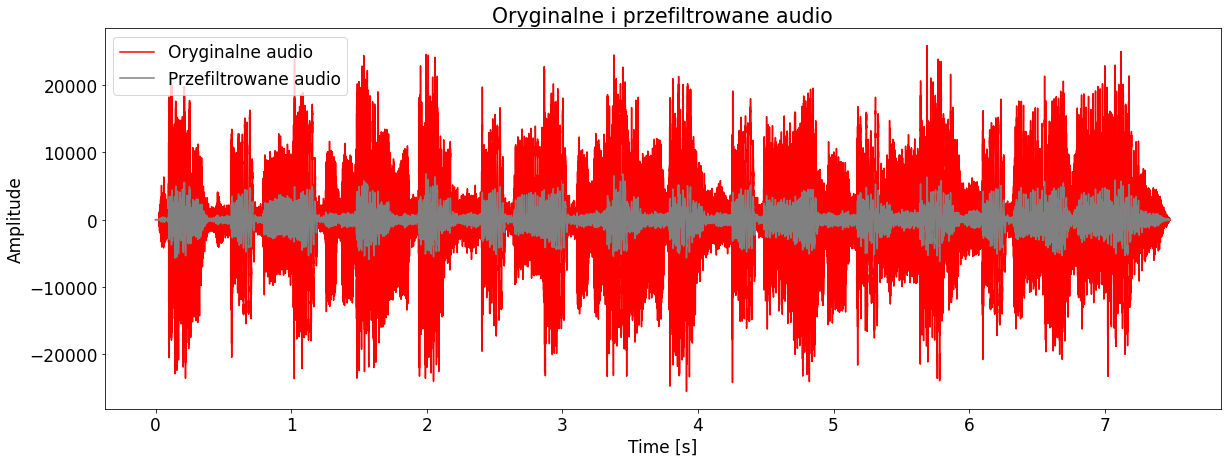

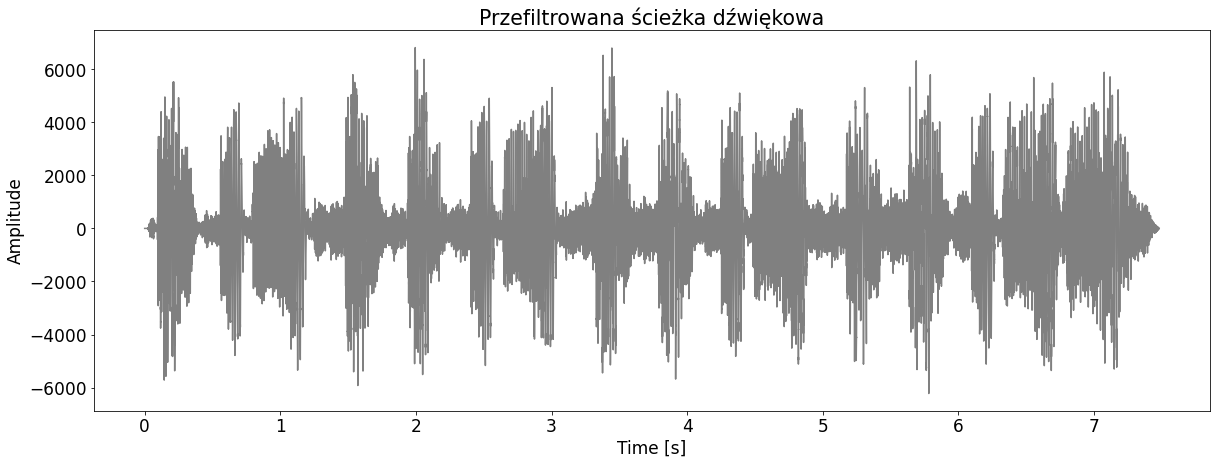

In [60]:
#Wczytanie pliku audio
fs, x = read('epic_sax_guy_single_channel.wav')
#Określenie ilości filtrów
M = 32
#Wartości decyamcji i upsamplingu. Wartość k powinna być równa wartości L.
k = 32
L = 32

#Brak manipulacji sygnałem
#eq = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

#Wyciszenie najniższych częstotliwości
#eq = [0.1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

#Losowo wybrane wzmocnienia i tłumienia różnych podpasm
#eq = [0.6, 0.4, 2, 3, 1, 8, 5, 3, 0.3, 5, 2, 1, 0.1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

#Wyciszenie wysokich częstotliwości
#eq = [1, 1, 1, 1, 1, 1, 1, 1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

#Wyciszenie niskich częstotliwości
#eq = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

#Podbicie najniższych częstotliwości
eq = [10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

#Generacja filtrów
p, h, g = prototype_filters(M)
#Equalizacja sygnału
yout = Equalizer(x, h, g, k, L, eq)

#Nakreślenie i odtworzenie oryginalnego audio
plt.figure(figsize=(20, 7))
plt.plot(np.arange(0, len(x))*1/fs, x, color='r', label='Oryginalne audio')
plt.plot(np.arange(0, len(yout))*1/fs, yout, color=(0.5, 0.5, 0.5), label='Przefiltrowane audio')
plt.legend()
plt.title('Oryginalne i przefiltrowane audio')
plt.ylabel('Amplitude')
plt.xlabel('Time [s]')
plt.show()
display(ipd.Audio(data=x, rate=fs))

#Nakreślenie i odtworzenie zmanipulowanego audio.
plt.figure(figsize=(20, 7))
plt.plot(np.arange(0, len(yout))*1/fs, yout, color=(0.5, 0.5, 0.5))
plt.title('Przefiltrowana ścieżka dźwiękowa')
plt.ylabel('Amplitude')
plt.xlabel('Time [s]')
plt.show()
display(ipd.Audio(data=yout, rate=fs))

# Odpowiedź częstotliwościowa filtrów.

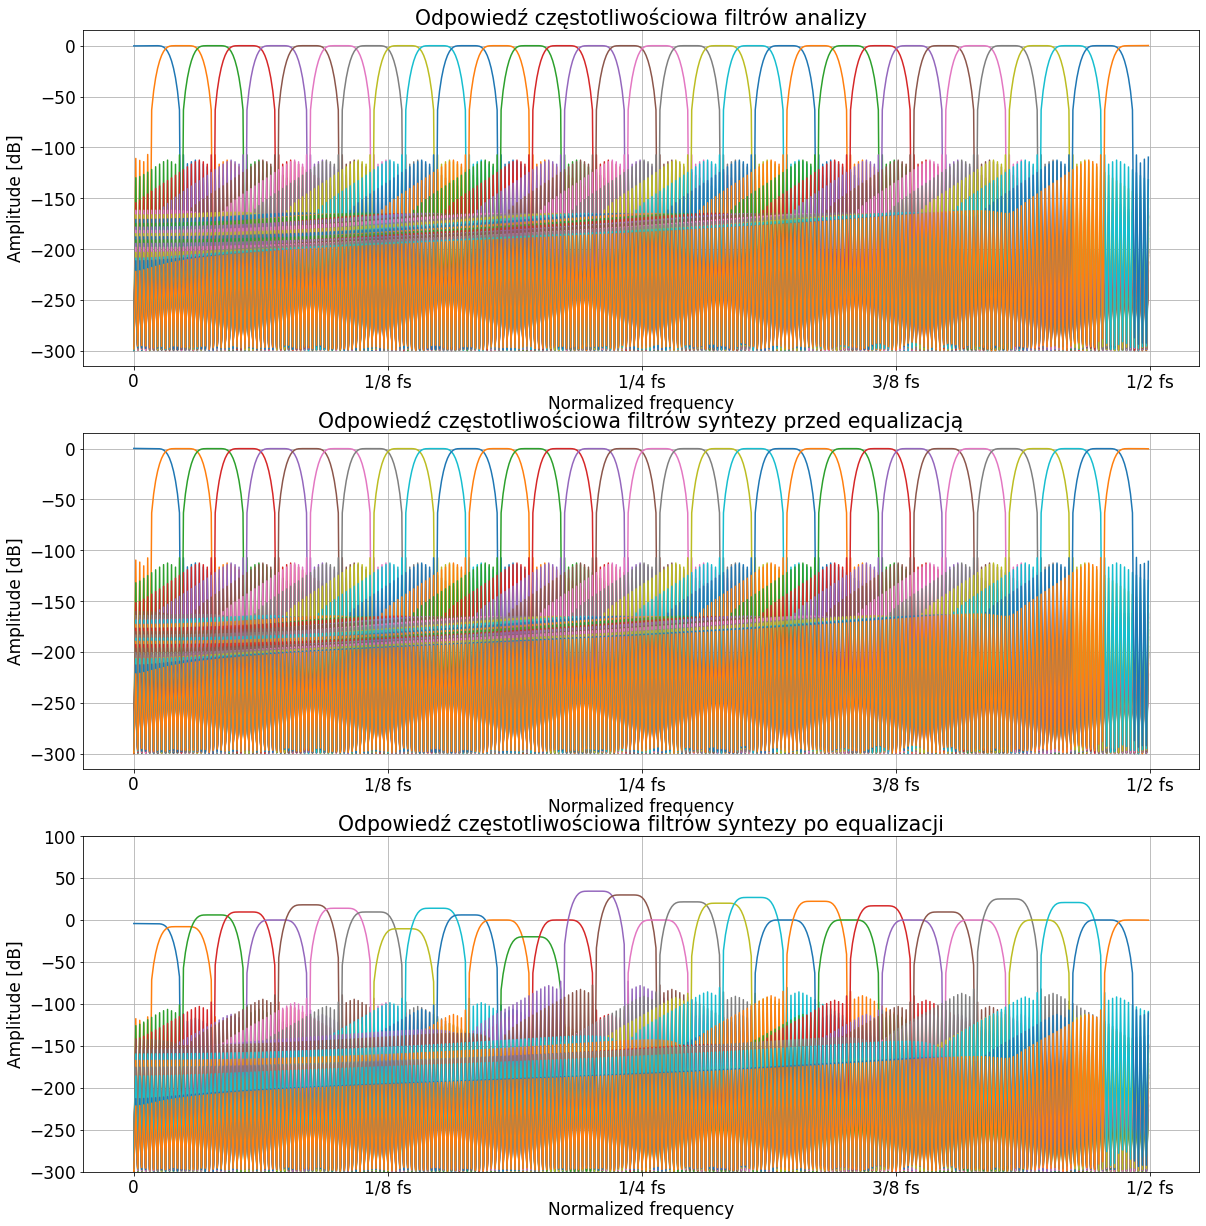

In [54]:
'''
Ze względu konstrukcje funkcji equalizer() zastosowano w tym przypadku samo wymnożenie odpowiedzi filtrów 
syntezy przez wektor 'eq' w celu demonstracji odpowiedzi częstotliwościowej filtrów przed i po equalizacji. 
'''
p, h, g = prototype_filters(M)
eq = [0.6, 0.4, 2, 3, 1, 8, 5, 3, 0.3, 5, 2, 1, 0.1, 1, 52, 31, 1, 12, 10, 22, 1, 13, 1, 7, 1, 3, 1, 18, 1, 11, 1, 1]
eq = np.array(eq).reshape((32, 1))
gprim = g*eq

fig, ax = plt.subplots(3, 1, figsize=(20, 21))

for k in range(M):
    _, H = scipy.signal.freqz(h[k])
    ax[0].plot(20*np.log10(abs(H)+1e-15), label='$H_{}$'.format(k))
ax[0].grid()
ax[0].set_title('Odpowiedź częstotliwościowa filtrów analizy')
ax[0].set_xlabel('Normalized frequency')
ax[0].set_ylabel('Amplitude [dB]')
ax[2].set_ylim((-300, 100))
ax[0].set_xticks([0, len(H)/4, len(H)/2, 3*len(H)/4, len(H)])
ax[0].set_xticklabels(['0', r'1/8 fs', '1/4 fs', '3/8 fs', '1/2 fs'])

for k in range(M):
    w, G = scipy.signal.freqz(g[k])
    ax[1].plot(20*np.log10(abs(G)+1e-15), label='$G_{}$'.format(k))
ax[1].grid()
ax[1].set_title('Odpowiedź częstotliwościowa filtrów syntezy przed equalizacją')
ax[1].set_xlabel('Normalized frequency')
ax[1].set_ylabel('Amplitude [dB]')
ax[2].set_ylim((-300, 100))
ax[1].set_xticks([0, len(G)/4, len(G)/2, 3*len(G)/4, len(G)])
ax[1].set_xticklabels(['0', r'1/8 fs', '1/4 fs', '3/8 fs', '1/2 fs'])

for k in range(M):
    w, G = scipy.signal.freqz(gprim[k])
    ax[2].plot(20*np.log10(abs(G)+1e-15), label='$G_{}$'.format(k))
ax[2].grid()
ax[2].set_title('Odpowiedź częstotliwościowa filtrów syntezy po equalizacji')
ax[2].set_xlabel('Normalized frequency')
ax[2].set_ylabel('Amplitude [dB]')
ax[2].set_ylim((-300, 100))
ax[2].set_xticks([0, len(G)/4, len(G)/2, 3*len(G)/4, len(G)])
ax[2].set_xticklabels(['0', r'1/8 fs', '1/4 fs', '3/8 fs', '1/2 fs'])
    
plt.show()
